##  Modeling the Impact of Lateral Flow Parameterizations on Total Evapotranspiration in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

One part of the Clark et al. (2015) study explored the impact of the lateral flux of liquid water on total evapotranspiration (ET) using a SUMMA model for the Reynolds Mountain East catchment. This study looked at the sensitivity of the different model representation of the lateral flux of liquid water, which determines the availability of soil water.

In this Jupyter Notebook, the pySUMMA library is used to reproduce this analysis. First, the latertal flux from the soil profile are described. Next, the Methods section describes how the pySUMMA can be used to create three different lateral model representation of the Reynolds Mountain East catchment model, 1d Richards', lumped topmodel, and distributed topmodel. The Results section shows how to use pySUMMA and the Pandas library to reproduce Figure 8(right) from Clark et al. (2015).

Collectively, this Jupyter Notebook serves as an example of how hydrologic modeling can be conducted directly within a Jupyter Notebook by leveraging the pySUMMA library. 

 |                    Method                   | 1dRichards' |   Lumped Topmodel |   Distributed Topmodel |
 |---------------------------------------------|-------------|-------------------|------------------------|
 |         groundwater parameterization        | noXplict    | qTopmodl          | qTopmodl               |
 |       hydraulic conductivity profile        | constant    | pow_prof          | pow_prof               |
 |lower boundary condition for soil hydrology  | drainage    | zeroFlux          | zeroFlux               |
 |thermal conductivity representation for soil | mixConstit  | funcSoilWet       | funcSoilWet            |

## 2. Background

### The Transpiration from soil layers available in SUMMA

In [159]:
#import libraries to display equations within the notebook
from IPython.display import display, Math, Latex

### Latertal flux from the soil profile

The soil columns can be hydrologically connected, such that the lateral flux from upslope soil columns is the inflow to downslope soil columns, or hydrologically-disconnected (using one or many soil columns), in which case the lateral flux of water from soil columns is assumed to flow directly into the river network.

The continuity equation for sub-surface storage (i.e., below the water table) can be written for a given model element as [Wigmosta et al., 1994]

\begin{equation*}
Q_{dr} = \frac{dz_{wt}}{dt} = \frac{Q_{out}-Q_{in}}{A} - q_{rchg}
\end{equation*}

$Q_{dr} = (\theta_{sat}^{soil} - \theta_{fc}^{soil}) $ : “drainable” porosity, $\theta_{fc}^{soil}$ : the field capacity of soil, $z_{wt}$ $(m)$ : the depth to the water table

$Q_{out}$ and $Q_{in}$ $(m^{3}/s)$: the lateral inflow and outflow, $q_{rchg}$ $(m/s)$ : the vertical recharge rate, $A$ $(m^2)$ : the element area

#### Storage-based implementation to represent lateral flow between soil columns

The “drainable” water storage and the maximum drainable water storage can be given as
\begin{equation*}
W_{dr}^{soil} = \int_{z_{crit}}^{z_{soil}}\ [\theta_{liq}^{soil} (z) - \theta_{fc}^{soil} ] \mathrm{d}z, \          W_{dr,max}^{soil} = \phi_{dr}z_{soil}
\end{equation*}

$\theta_{liq}^{soil} (z)$ : the volumetric liquid water content at soil depth z, $z_{crit}$ : the lowest point in the soil profile where $\theta_{liq}^{soil}$ < $\theta_{fc}^{soil}$

#### The total lateral outflow

\begin{equation*}
Q_{out} = x_{len}tan(\beta) \frac{K_{sat}^{0} W_{dr,max}^{soil}}{\phi_{dr}n_{sf}}[\frac{W_{dr}^{soil}}{W_{dr,max}^{soil}}]^{n_{sf}}
\end{equation*}

$\beta$ : the gradient in the land surface, used to approximate the water table gradient

#### The total lateral flux

\begin{equation*}
q_{base}^{soil} =  \frac{Q_{out}-Q_{in}}{A}
\end{equation*}

The total lateral flux $q_{base}^{soil}$ can then be apportioned to individual soil layers, obtained after spatial discretization described in Clark et al. [2015b], to provide the lateral flow sink term

\begin{equation*}
(S_{lf})_{j} = (w_{tv})_{j}   q_{base}^{soil}
\end{equation*}

$(w_{tv})_{j}$ : the ratio of the transmissivity of the $j$-th layer to the total transmissivity

The above descriptions are taken from the lateral flux from the soil profile section(3.2.3.5) within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

In [1]:
from ipyleaflet import Map, GeoJSON
import json

In [2]:
m = Map(center=[43.06745, -116.75489], zoom=15)
with open('reynolds_geojson_latlon.geojson') as f:
    data = json.load(f)
g = GeoJSON(data=data)
m.add_layer(g)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### 2) Download TestCases from HS and Installation to prepare SUMMA simulation

In [3]:
# To authenticate using HTTP Basic authentication.
from hs_restclient import HydroShare, HydroShareAuthBasic
hs = HydroShare()

In [4]:
# import utils.py to download TestCases from HS, unzip and installation
from pysumma.utils import utils

In [5]:
# define directory where you save SUMMA TestCases
save_filepath = '/glade/u/home/ydchoi'

In [6]:
# assign resource id of SUMMA TestCases on HS (Now I uploaded SUMMA TestCases in My Resources(status=Private) on HS )
resource_id = 'a0105d479c334764ba84633c5b9c1c01'

In [2]:
# call install_test_cases_hs method to download TestCase from HS, unzip and install the TestCase.
hs_path = utils.install_test_cases_hs(hs, resource_id, save_filepath)

In [7]:
# if you already have TestCase in your local, you can skip previous statement
hs_path = '/glade/u/home/ydchoi/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents'

### 3) Create pySUMMA Simulation Object of 1d Richards method and Run SUMMA Model

In [8]:
from pysumma.Simulation import Simulation
from pysumma.Plotting import Plotting

In [9]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_1dRichards = Simulation(hs_path + '/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_1dRichards.txt')

In [10]:
# set SUMMA executable file
S_1dRichards.executable = "/glade/u/home/ydchoi/summa/bin/summa.exe"

In [11]:
# check the simulation start and finish times
S_1dRichards.decision_obj.simulStart.value, S_1dRichards.decision_obj.simulFinsh.value

('2002-07-01 00:00', '2008-09-30 00:00')

In [12]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_1dRichards.decision_obj.groundwatr.options, S_1dRichards.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'noXplict')

In [13]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_1dRichards.decision_obj.hc_profile.options, S_1dRichards.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'constant')

In [14]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_1dRichards.decision_obj.bcLowrSoiH.options, S_1dRichards.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'drainage')

In [15]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_1dRichards.decision_obj.thCondSoil.options, S_1dRichards.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'mixConstit')

In [16]:
# check Basin variable meta data in file manager file
S_1dRichards.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [17]:
# check Basin Parameter info data in file manager file
S_1dRichards.basin_par.filename

'summa_zBasinParamInfo.txt'

In [18]:
# check Forcing list data in file manager file
S_1dRichards.forcing_list.filename

'summa_zForcingFileList_riparianAspen_1dRichards.txt'

In [19]:
# check Initial condition data in file manager file
S_1dRichards.initial_cond.filename

'summa_zInitialCond.nc'

In [20]:
# run the model giving the output the suffix "1dRichards_docker_develop" and get "results_1dRichards" object
results_1dRichards, output_R = S_1dRichards.execute(run_suffix="1dRichards_hs", run_option = 'local')

### 4) Create pySUMMA Simulation Object of Lumped Topmodel method and Run SUMMA Model

In [21]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_lumpedTopmodel = Simulation(hs_path + '/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_lumpedTopmodel.txt')

In [22]:
# set SUMMA executable file
S_lumpedTopmodel.executable = "/glade/u/home/ydchoi/summa/bin/summa.exe"

In [23]:
# check the simulation start and finish times
S_lumpedTopmodel.decision_obj.simulStart.value, S_lumpedTopmodel.decision_obj.simulFinsh.value

('2001-07-01 00:00', '2008-09-30 00:00')

In [24]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_lumpedTopmodel.decision_obj.groundwatr.options, S_lumpedTopmodel.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'qTopmodl')

In [25]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_lumpedTopmodel.decision_obj.hc_profile.options, S_lumpedTopmodel.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'pow_prof')

In [26]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_lumpedTopmodel.decision_obj.bcLowrSoiH.options, S_lumpedTopmodel.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'zeroFlux')

In [27]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_lumpedTopmodel.decision_obj.thCondSoil.options, S_lumpedTopmodel.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'funcSoilWet')

In [28]:
# check Basin variable meta data in file manager file
S_lumpedTopmodel.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [29]:
# check Basin Parameter info data in file manager file
S_lumpedTopmodel.basin_par.filename

'summa_zBasinParamInfo.txt'

In [30]:
# check Forcing list data in file manager file
S_lumpedTopmodel.forcing_list.filename

'summa_zForcingFileList_riparianAspen_lumpedTopmodel.txt'

In [31]:
# check Initial condition data in file manager file
S_lumpedTopmodel.initial_cond.filename

'summa_zInitialCond.nc'

In [32]:
# run the model giving the output the suffix "lumpedTopmodel_docker_develop" and get "results_lumpedTopmodel" object
results_lumpedTopmodel, output_LT = S_lumpedTopmodel.execute(run_suffix="lumpedTopmodel_hs", run_option = 'local')

### 5) Create pySUMMA Simulation Object of Distributed Topmodel method and Run SUMMA Model

In [33]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_distributedTopmodel = Simulation(hs_path + '/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_distributedTopmodel.txt')

In [34]:
# set SUMMA executable file
S_distributedTopmodel.executable = "/glade/u/home/ydchoi/summa/bin/summa.exe"

In [35]:
# check the simulation start and finish times
S_distributedTopmodel.decision_obj.simulStart.value, S_distributedTopmodel.decision_obj.simulFinsh.value

('2001-07-01 00:00', '2008-09-30 00:00')

In [36]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_distributedTopmodel.decision_obj.groundwatr.options, S_distributedTopmodel.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'qTopmodl')

In [37]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_distributedTopmodel.decision_obj.hc_profile.options, S_distributedTopmodel.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'pow_prof')

In [38]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_distributedTopmodel.decision_obj.bcLowrSoiH.options, S_distributedTopmodel.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'zeroFlux')

In [39]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_distributedTopmodel.decision_obj.thCondSoil.options, S_distributedTopmodel.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'funcSoilWet')

In [40]:
# check Basin variable meta data in file manager file
S_distributedTopmodel.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [41]:
# check Basin Parameter info data in file manager file
S_distributedTopmodel.basin_par.filename

'summa_zBasinParamInfo.txt'

In [42]:
# check Forcing list data in file manager file
S_distributedTopmodel.forcing_list.filename

'summa_zForcingFileList_fullDist.txt'

In [43]:
# check Initial condition data in file manager file
S_distributedTopmodel.initial_cond.filename

'summa_zInitialCond_disTop.nc'

In [44]:
# run the model giving the output the suffix "distributedTopmodel_docker_develop" and get "results_distributedTopmodel" object
results_distributedTopmodel, output_DT = S_distributedTopmodel.execute(run_suffix="distributedTopmodel_hs", run_option = 'local')

## 4. Results

### Recreate the Figure 8(right) plot from Clark et al., 2015: The total ET Sensitivity for the model representation of the lateral flux of liquid water

In [45]:
from pysumma.Plotting import Plotting
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import pandas as pd
jtplot.figsize(x=10, y=10)

#### 4.1) Create function to calculate Total ET of hour of day from SUMMA output for the period 1 June to 20 August 2007

In [46]:
def calc_total_et(et_output_df):
    # Total Evapotranspiration = Canopy Transpiration + Canopy Evaporation + Ground Evaporation
    # Change unit from kgm-2s-1 to mm/hr (mulpitle 3600)
    total_et_data = (et_output_df['scalarCanopyTranspiration'] + et_output_df['scalarCanopyEvaporation'] + et_output_df['scalarGroundEvaporation'])*3600
    # create dates(X-axis) attribute from ouput netcdf
    dates = total_et_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = total_et_data.data
    # create two dimensional tabular data structure 
    total_et_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_et_df.index = total_et_df.index.round("H")
    # set the time period to display plot 
    total_et_df = total_et_df.loc["2007-06-01":"2007-08-20"]
    # resample data by the average value hourly
    total_et_df_hourly = total_et_df.resample("H").mean()
    # resample data by the average for hour of day
    total_et_by_hour = total_et_df_hourly.groupby(total_et_df_hourly.index.hour).mean()
    return total_et_by_hour

#### 4.2) Get hour of day output of the Parameterization of Later Flux of Liquid water for the period 1 June to 20 August 2007

In [47]:
# get hour of day output using calc_total_et method (1d Richards method appied 1 hru)
hour_1dRichards = calc_total_et(results_1dRichards)

In [48]:
# get hour of day output using calc_total_et method (lumped Topmodel method appied 1 hru)
hour_lumpedTopmodel = calc_total_et(results_lumpedTopmodel)

In [49]:
# get hour of day output using calc_total_et method (lumped Topmodel method appied 6 hru)
hour_distributedTopmodel = calc_total_et(results_distributedTopmodel)

In [50]:
# check the area of each hru to calculate areal average ET
trial_parameter_nc = Plotting(S_distributedTopmodel.setting_path.filepath+S_distributedTopmodel.local_attr.value)
trial_parameter = trial_parameter_nc.open_netcdf()
# read the area of each hru
trial_parameter['HRUarea']

<xarray.DataArray 'HRUarea' (hru: 6)>
array([ 78300.,  32700.,  18600.,  32800., 168200.,  45400.])
Dimensions without coordinates: hru
Attributes:
    long_name:  Area of each HRU
    units:      m^2

In [51]:
# calculate areal average ET for distributed Topmodel
hour_distributedTopmodel_average = (hour_distributedTopmodel[0]*78300 + hour_distributedTopmodel[1]*32700 + hour_distributedTopmodel[2]*18600 + hour_distributedTopmodel[3]*32800 + hour_distributedTopmodel[4]*168200 + hour_distributedTopmodel[5]*45400)/(78300+32700+18600+32800+168200+45400)

#### 4.3) Combine the Parameterization of the Lateral Flux of Liquid Water into a single Pandas Dataframe

In [52]:
# Combine ET for model representation of the lateral flux of liquid water
ET_Combine = pd.concat([hour_1dRichards, hour_lumpedTopmodel, hour_distributedTopmodel_average], axis=1)
# add label 
ET_Combine.columns = ["Baseflow = 1D Richards'", 'Baseflow = Topmodel(lumped)', 'Baseflow = Topmodel(distributed)']

In [53]:
ET_Combine

,Baseflow = 1D Richards',Baseflow = Topmodel(lumped),Baseflow = Topmodel(distributed)
0,-0.009759,-0.010652,-0.008157
1,-0.009683,-0.010422,-0.008281
2,-0.009432,-0.010101,-0.008168
3,-0.008611,-0.009091,-0.007745
4,-0.007250,-0.007702,-0.007167
5,-0.006486,-0.006933,-0.007362
6,-0.007677,-0.008216,-0.007462
7,-0.007290,-0.007538,-0.006375
8,-0.006116,-0.006224,-0.005601
9,-0.005570,-0.005726,-0.006520


#### 4.4) Add obervation data in Aspen station in Reynolds Mountain East to the plot

In [54]:
# create pySUMMA Plotting Object
Val_eddyFlux = Plotting(hs_path + '/summaTestCases_2.x/testCases_data/validationData/ReynoldsCreek_eddyFlux.nc')

In [55]:
# read Total Evapotranspiration(LE-wpl) from validation netcdf file
Obs_Evapotranspitaton = Val_eddyFlux.ds['LE-wpl']
# create dates(X-axis) attribute from validation netcdf file
dates = Obs_Evapotranspitaton.coords['time'].data
# Change unit from Wm-2 to mm/hr (1 Wm-2 = 0.0864 MJm-2day-1, 1 MJm-2day-1 = 0.408 mmday-1, 1day = 24h)
data_values = Obs_Evapotranspitaton.data*0.0864*0.408/24
# create two dimensional tabular data structure 
df = pd.DataFrame(data_values, index=dates)
# set the time period to display plot
df_filt = df.loc["2007-06-01":"2007-08-20"]
# select aspen obervation station among three different stations
df_filt.columns = ['-','Observation (aspen)','-']
# resample data by the average for hour of day
df_gp_hr = df_filt.groupby([df_filt.index.hour, df_filt.index.minute]).mean()
# reset index so each row has an hour an minute column
df_gp_hr.reset_index(inplace=True)
# add hour and minute columns for plotting
xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.

#### 4.5) Plotting output of the Parameterization of the Lateral Flux of Liquid Water and observation data

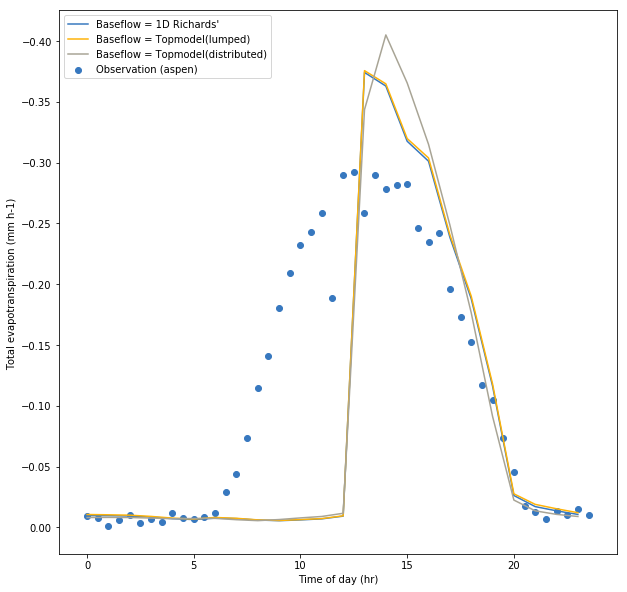

In [56]:
# create plot with the Parameterization of model representation of the lateral flux of liquid water
ET_Combine_Graph = ET_Combine.plot()
# invert y axis
ET_Combine_Graph.invert_yaxis()
# plot scatter with x='xvals', y='Observation (aspen)'
ET_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'])
# add x, y label
ET_Combine_Graph.set(xlabel='Time of day (hr)', ylabel='Total evapotranspiration (mm h-1) ')
# show up the legend
ET_Combine_Graph.legend()

## 5. Discussion

As stated in Clark et al., 2015, the following insights can be gained from this analysis:

* The simulation in Figure 8 illustrates the model representation of the lateral flux of liquid water, which determines (in part) the availability of soil water.

* The results in Figure 8 demonstrate strong sensitivities the lateral flow parameterization. The parameterizations based on power-law transmissivity profiles (both lumped and distributed) have more drainage of soil water at deeper soil layers; however, the distributed simulations include inflow from upslope, resulting in more plant-available soil water and an increase in transpiration. Taken together, the results in Figure 8 illustrate the strong interdependencies among different modeling decisions, which of course complicate discriminating among competing process parameterizations.

## 6. Post notebook and simulation results back to Hydroshare

In [72]:
# write meta data such as abstract, title, keywords, rtype
abstract = 'output of SUMMA(Fig8_right)'
title = 'output of SUMMA(Fig8_right)'
keywords = ('SUMMA', 'Hydrologic Model')
rtype = 'GenericResource'
fpath = output_R
metadata = '[{"creator":{"name":"Youngdon Choi"}}, {"creator":{"name":"Jeffrey Sadler"}}]'
extra_metadata = '{"key-1": "value-1", "key-2": "value-2"}'

In [73]:
# post simulation results of 1d Richards' method back to HS
auth = HydroShareAuthBasic(username='****', password='****')
hs = HydroShare(auth=auth)
resource_id = hs.createResource(rtype, title, resource_file=fpath, keywords=keywords, abstract=abstract, metadata=metadata, extra_metadata=extra_metadata)

In [74]:
# post simulation results of lumpted topmodel back to HS
npath = output_LT
resource_id = hs.addResourceFile('ffccace58c3a4f15b4fc5b9445c4e918', npath)

In [75]:
# post simulation results of distributed topmodel back to HS
npath = output_DT
resource_id = hs.addResourceFile('ffccace58c3a4f15b4fc5b9445c4e918', npath)

#### Save this notebook file to add the notebook to rhe resource of summa output

In [76]:
# add a notebook to the resource of summa output
npath = '/glade/u/home/ydchoi/sopron_2018/notebooks/pySUMMA_Demo_Example_Fig8_right_Using_TestCase_from_Hydroshare.ipynb'
# check the resource id on HS that created.
resource_id = hs.addResourceFile('ffccace58c3a4f15b4fc5b9445c4e918', npath)

## 7. make this resource public

In [ ]:
# check the resource id 
C_resource_id = 'ffccace58c3a4f15b4fc5b9445c4e918'

In [ ]:
# make a resource public
hs.setAccessRules(C_resource_id, public=True)